In [1]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-2dyvwl34
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-2dyvwl34
  Created wheel for tensorflow-examples: filename=tensorflow_examples-a45ec3b71d3620b21cd8ae9c8cd0510ddb4a5c8f_-py3-none-any.whl size=270995 sha256=e02821f68c0e097769d2ead7e8c879e1d66a4cea92293194878ae9497c09795c
  Stored in directory: /tmp/pip-ephem-wheel-cache-ukrtagnc/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [2]:
import tensorflow as tf

In [3]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [4]:
from google.colab import files

background_dataset_zipped = files.upload()

Saving ContentDataset.zip to ContentDataset.zip


In [5]:
style_dataset_zipped = files.upload()

Saving FinniganDataset.zip to FinniganDataset.zip


In [12]:
!mkdir -p Images/train/Contents Images/train/Styles

In [13]:
background_dataset_zipped_filename = list(background_dataset_zipped.keys())[0]
!unzip -d Images/train/Contents $background_dataset_zipped_filename

Archive:  ContentDataset.zip
  inflating: Images/train/Contents/Background-00001.jpg  
  inflating: Images/train/Contents/Background-00002.jpg  
  inflating: Images/train/Contents/Background-00003.jpg  
  inflating: Images/train/Contents/Background-00004.jpg  
  inflating: Images/train/Contents/Background-00005.jpg  
  inflating: Images/train/Contents/Background-00006.jpg  
  inflating: Images/train/Contents/Background-00007.jpg  
  inflating: Images/train/Contents/Background-00008.jpg  
  inflating: Images/train/Contents/Background-00009.jpg  
  inflating: Images/train/Contents/Background-00010.jpg  
  inflating: Images/train/Contents/Background-00011.jpg  
  inflating: Images/train/Contents/Background-00012.jpg  
  inflating: Images/train/Contents/Background-00013.jpg  
  inflating: Images/train/Contents/Background-00014.jpg  
  inflating: Images/train/Contents/Background-00015.jpg  
  inflating: Images/train/Contents/Background-00016.jpg  
  inflating: Images/train/Contents/Backgrou

In [15]:
style_dataset_zipped_filename = list(style_dataset_zipped.keys())[0]
!unzip -d Images/train/Styles $style_dataset_zipped_filename

Archive:  FinniganDataset.zip
  inflating: Images/train/Styles/Finnigan-00001.jpg  
  inflating: Images/train/Styles/Finnigan-00002.jpg  
  inflating: Images/train/Styles/Finnigan-00003.jpg  
  inflating: Images/train/Styles/Finnigan-00004.jpg  
  inflating: Images/train/Styles/Finnigan-00005.jpg  
  inflating: Images/train/Styles/Finnigan-00006.jpg  
  inflating: Images/train/Styles/Finnigan-00007.jpg  
  inflating: Images/train/Styles/Finnigan-00008.jpg  
  inflating: Images/train/Styles/Finnigan-00009.jpg  
  inflating: Images/train/Styles/Finnigan-00010.jpg  
  inflating: Images/train/Styles/Finnigan-00011.jpg  
  inflating: Images/train/Styles/Finnigan-00012.jpg  
  inflating: Images/train/Styles/Finnigan-00013.jpg  
  inflating: Images/train/Styles/Finnigan-00014.jpg  
  inflating: Images/train/Styles/Finnigan-00015.jpg  
  inflating: Images/train/Styles/Finnigan-00016.jpg  
  inflating: Images/train/Styles/Finnigan-00017.jpg  
  inflating: Images/train/Styles/Finnigan-00018.jpg 

In [98]:
builder = tfds.ImageFolder('Images')
ds = builder.as_dataset(split='train', shuffle_files=True)

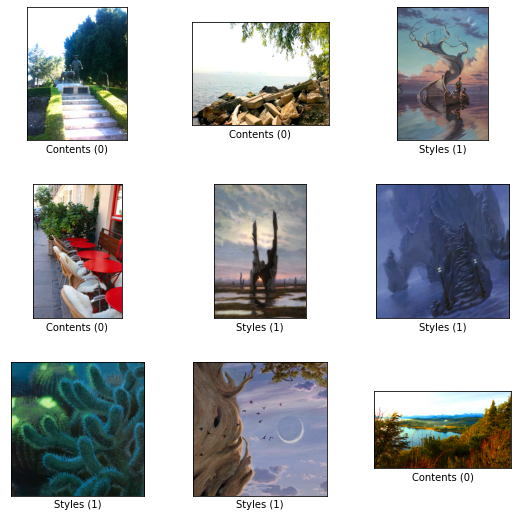

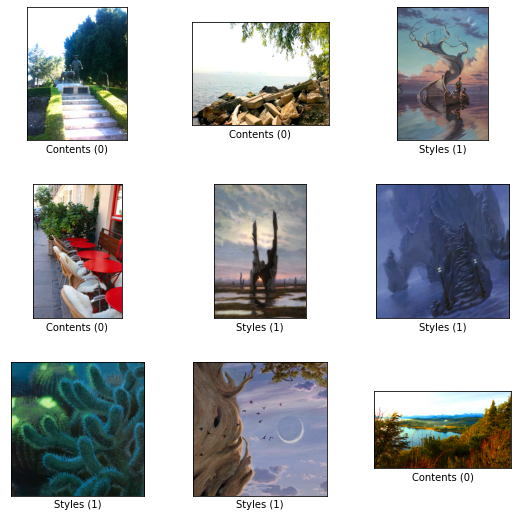

In [17]:
tfds.show_examples(ds, builder.info)

In [39]:
content_images = ds.filter(lambda i: i['label'] == 0)
style_images = ds.filter(lambda i: i['label'] == 1)

In [32]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [33]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [34]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [101]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [102]:
def preprocess_image_train(record):
  image = record['image']
  image = random_jitter(image)
  image = normalize(image)
  return image

In [103]:
def preprocess_image_test(record):
  image = record['image']
  image = normalize(image)
  return image

In [104]:
train_content = content_images.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_styles = style_images.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_content = content_images.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_styles = style_images.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [105]:
sample_content = next(iter(train_content))
sample_style = next(iter(train_styles))

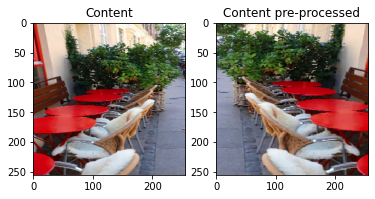

In [106]:
plt.subplot(121)
plt.title('Content')
plt.imshow(sample_content[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Content pre-processed')
plt.imshow(random_jitter(sample_content[0]) * 0.5 + 0.5)

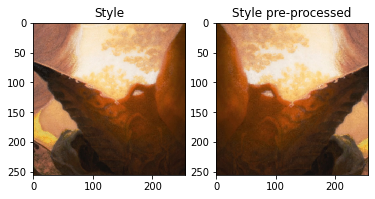

In [125]:
plt.subplot(121)
plt.title('Style')
plt.imshow(sample_style[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Style pre-processed')
plt.imshow(random_jitter(sample_style[0]) * 0.5 + 0.5)

In [108]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

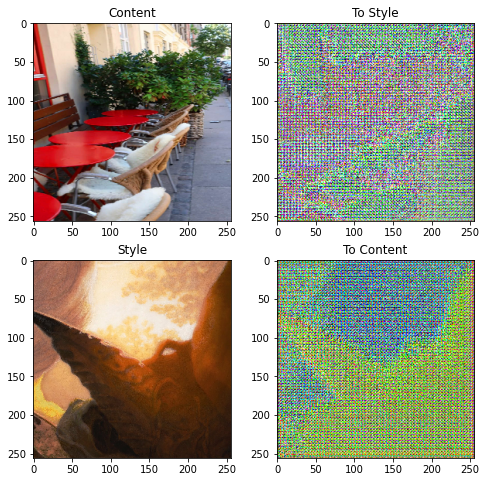

In [109]:
to_style = generator_g(sample_content)
to_content = generator_f(sample_style)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_content, to_style, sample_style, to_content]
title = ['Content', 'To Style', 'Style', 'To Content']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

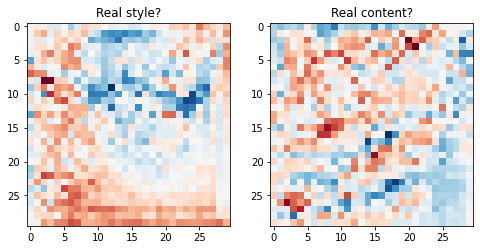

In [110]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Real style?')
plt.imshow(discriminator_y(sample_style)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Real content?')
plt.imshow(discriminator_x(sample_content)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Loss functions

In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input `x` and the target `y` pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

The discriminator loss and the generator loss are similar to the ones used in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_generator).

In [111]:
LAMBDA = 10

In [112]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [113]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [114]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

Cycle consistency means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the  original sentence.

In cycle consistency loss, 

* Image $X$ is passed via generator $G$ that yields generated image $\hat{Y}$.
* Generated image $\hat{Y}$ is passed via generator $F$ that yields cycled image $\hat{X}$.
* Mean absolute error is calculated between $X$ and $\hat{X}$.

$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$

$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$


![Cycle loss](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cycle_loss.png?raw=1)

In [115]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

As shown above, generator $G$ is responsible for translating image $X$ to image $Y$. Identity loss says that, if you fed image $Y$ to generator $G$, it should yield the real image $Y$ or something close to image $Y$.

If you run the zebra-to-horse model on a horse or the horse-to-zebra model on a zebra, it should not modify the image much since the image already contains the target class.

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [116]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Initialize the optimizers for all the generators and the discriminators.

In [117]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints

In [118]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


## Training

Note: This example model is trained for fewer epochs (40) than the paper (200) to keep training time reasonable for this tutorial. Predictions may be less accurate. 

In [119]:
EPOCHS = 5

In [120]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [121]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

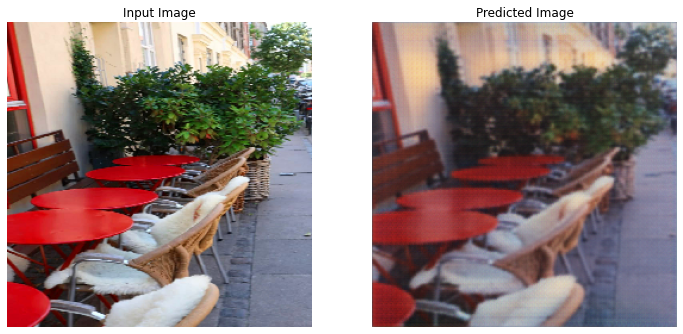

Saving checkpoint for epoch 5 at ./checkpoints/train/ckpt-3
Time taken for epoch 5 is 63.00429177284241 sec



In [123]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_content, train_styles)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_content) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_content)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

## Generate using test dataset

In [124]:
# Run the trained model on the test dataset
for inp in test_content.take(5):
  generate_images(generator_g, inp)

InvalidArgumentError: ignored

## Next steps

- tqdm for progress
- More epochs
  - Improve timing on existing epochs
- Switch to ResNet instead of U-Net ([source](https://arxiv.org/abs/1703.10593))